In [1]:
import cv2
import numpy as np

In [32]:
img = cv2.imread('/media/rideflux/T7/2024-Summer-Internship/벚꽃/04-03/2024-04-03-15-19-18_solati_v5_5_17-38/camera_0/31.jpg')
# img = cv2.imread('/media/rideflux/T7/2024-Summer-Internship/NIA2021/10002/image0/10002_000.jpg')
img = cv2.resize(img, (1280, 720))
img = cv2.fastNlMeansDenoisingColored(img,None,10,10)

In [35]:
# BGR 채널 분리
b, g, r = cv2.split(img)

# 각 채널에 대해 히스토그램 평활화 적용
b_eq = cv2.equalizeHist(b)
g_eq = cv2.equalizeHist(g)
r_eq = cv2.equalizeHist(r)

# 평활화된 채널들을 다시 합침
adjust = cv2.merge((b_eq, g_eq, r_eq))

# BGR에서 HSV로 변환
hsv = cv2.cvtColor(adjust, cv2.COLOR_BGR2HSV)

# 흰색 차선 마스크 생성
lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 25, 255])
white_mask = cv2.inRange(hsv, lower_white, upper_white)

# 노란색 차선 마스크 생성
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])
yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

lower_yellow = np.array([106, 36, 154])  # H-10, S-10, V-50
upper_yellow = np.array([126, 56, 255])  # H+10, S+10, V+50
yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
# 흰색과 노란색 마스크 결합
combined_mask = cv2.bitwise_or(white_mask, yellow_mask)

# 결과 시각화
combined_output = cv2.bitwise_and(img, img, mask=combined_mask)

cv2.imshow('Original Image', img)
# cv2.imshow('White Mask', white_output)
# cv2.imshow('Yellow Mask', yellow_output)
cv2.imshow('Combined Mask', combined_output)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [36]:
edges = cv2.Canny(combined_output,50,150)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)

road_mask = np.zeros_like(img)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if y1 > img.shape[0] // 2 and y2 > img.shape[0] // 2:  # 이미지 하단 부분에 있는 직선만 고려
            cv2.line(road_mask, (x1, y1), (x2, y2), 255, 2)

# road_only = cv2.bitwise_and(img, road_mask)
# cv2.imshow('original',img)
combined_img = cv2.addWeighted(img,1,road_mask,1,0)
cv2.imshow('roadmask',road_mask)
cv2.imshow('masked',combined_img)
cv2.imshow('edge',edges)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [37]:
# 그레이스케일 변환
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 엣지 검출 (Canny)
edges = cv2.Canny(gray, 50, 150)

# 컨투어 찾기
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# 빈 이미지 생성 (컨투어를 그리기 위해)
contour_img = np.zeros_like(img)

# 컨투어 그리기
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 1)

# 원본 이미지에 컨투어 그리기
img_with_contours = img.copy()
cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 2)

# 결과 시각화
cv2.imshow('Original img', img)
cv2.imshow('Edges', edges)
# cv2.imshow('Contours', contour_img)
# cv2.imshow('img with Contours', img_with_contours)
cv2.waitKey(0)
cv2.destroyAllWindows()

Canny-Hough

In [37]:
import cv2
import numpy as np
from sklearn.linear_model import RANSACRegressor
img = cv2.imread('/home/rideflux/Public/TrainingData/GeneralCase/Raw/30105/camera_0/102.jpg')
# img = cv2.imread('/media/rideflux/T7/2024-Summer-Internship/NIA2021/10010/image0/10010_100.jpg')
img = cv2.resize(img, (1280, 720))
img = cv2.fastNlMeansDenoisingColored(img,None,10,10)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 10, 150)
cv2.imshow('edge', edges)
# cv2.imshow('origin',img)
cv2.waitKey(0)
cv2.destroyAllWindows()



In [4]:
import cv2
import numpy as np
from sklearn.linear_model import RANSACRegressor
img = cv2.imread('/media/rideflux/T7/2024-Summer-Internship/벚꽃/04-03/2024-04-03-15-19-18_solati_v5_5_17-38/camera_0/31.jpg')
img = cv2.resize(img, (1280, 720))
img = cv2.fastNlMeansDenoisingColored(img,None,10,10)

height, width = img.shape[0], img.shape[1]
bottom_half = img[img.shape[0]//2:, :]

gray = cv2.cvtColor(bottom_half, cv2.COLOR_BGR2GRAY)
cv2.imshow('gray',gray)
dx = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
dy = cv2.Sobel(gray, cv2.CV_32F, 0, 1)

mag = cv2.magnitude(dx, dy)
mag = np.clip(mag, 0, 255).astype(np.uint8)

# dst = np.zeros(img.shape[:2], np.uint8)
dst = np.zeros((img.shape[0]//2, img.shape[1]), np.uint8)
dst[mag>150] = 255
cv2.imshow('dst',dst)

kernel = np.ones((2,2), np.uint8)
dilated_image = cv2.dilate(dst, kernel, iterations = 1)

### 허프 변환
lines = cv2.HoughLinesP(dilated_image, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=200)

road_mask = np.zeros_like(img)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if y1 > img.shape[0] // 2 and y2 > img.shape[0] // 2:
            cv2.line(road_mask, (x1, y1), (x2, y2), 255, 2)
            
combined_img = cv2.addWeighted(img,1,road_mask,1,0)


#### 사각형 검출
contours, _ = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# 사각형을 그리기 위한 이미지 복사본
rect_image = np.copy(bottom_half)

# 중심점을 저장할 리스트
centers = []

# 각 컨투어에 대해 사각형을 찾고 중심점을 계산
for contour in contours:
    # 컨투어의 최소 외접 사각형 찾기
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    # 사각형 그리기
    cv2.drawContours(rect_image, [box], 0, (0, 255, 0), 2)
    
    # 중심점 계산
    center = (int(rect[0][0]), int(rect[0][1]))
    centers.append(center)
    cv2.circle(rect_image, center, 5, (0, 0, 255), -1)

img[img.shape[0]//2:, :] = rect_image

# cv2.imshow('img',road_mask)
cv2.imshow('img',img)
# cv2.imshow('dst',dilated_image)
# cv2.imshow('contour',rect_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

[ WARN:0@83.786] global loadsave.cpp:241 findDecoder imread_('/media/rideflux/T7/2024-Summer-Internship/벚꽃/04-03/2024-04-03-15-19-18_solati_v5_5_17-38/camera_0/31.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [14]:
import cv2
import numpy as np
from sklearn.linear_model import RANSACRegressor
img = cv2.imread('/media/rideflux/T7/2024-Summer-Internship/벚꽃/04-03/2024-04-03-15-19-18_solati_v5_5_17-38/camera_0/31.jpg')
img = cv2.resize(img, (1280, 720))
img = cv2.fastNlMeansDenoisingColored(img,None,10,10)

height, width = img.shape[0], img.shape[1]
bottom_half = img[height//2:, :,2]
gray = cv2.cvtColor(bottom_half, cv2.COLOR_BGR2GRAY)
dx = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
dy = cv2.Sobel(gray, cv2.CV_32F, 0, 1)

mag = cv2.magnitude(dx, dy)
mag = np.clip(mag, 0, 255).astype(np.uint8)


# dst 크기를 하단 절반 크기로 변경
dst = np.zeros((img.shape[0]//2, img.shape[1]), np.uint8)
dst[mag > 200] = 255

kernel = np.ones((2, 2), np.uint8)
dilated_image = cv2.dilate(dst, kernel, iterations = 1)

### 허프 변환
lines = cv2.HoughLinesP(dilated_image, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=200)

road_mask = np.zeros_like(img)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # 하단 절반 이미지의 좌표를 전체 이미지의 좌표로 변환
        y1 += height // 2
        y2 += height // 2
        cv2.line(road_mask, (x1, y1), (x2, y2), 255, 2)

combined_img = cv2.addWeighted(img, 1, road_mask, 1, 0)

#### 사각형 검출
contours, _ = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# 사각형을 그리기 위한 이미지 복사본
rect_image = np.copy(bottom_half)

# 중심점을 저장할 리스트
centers = []

# 각 컨투어에 대해 사각형을 찾고 중심점을 계산
for contour in contours:
    # 컨투어의 최소 외접 사각형 찾기
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    # 사각형 그리기
    cv2.drawContours(rect_image, [box], 0, (0, 255, 0), 2)
    
    # 중심점 계산
    center = (int(rect[0][0]), int(rect[0][1]))
    centers.append(center)
    cv2.circle(rect_image, center, 5, (0, 0, 255), -1)

# # RANSAC을 사용하여 차선 모델링
# if len(centers) > 0:
#     centers = np.array(centers)
#     X = centers[:, 0].reshape(-1, 1)
#     y = centers[:, 1]
    
#     ransac = RANSACRegressor()
#     ransac.fit(X, y)
    
#     # 차선에 속하는 점들 선택
#     inlier_mask = ransac.inlier_mask_
#     inliers = centers[inlier_mask]
    
#     # 선택된 점들로 차선 그리기
#     for i in range(1, len(inliers)):
#         cv2.line(rect_image, tuple(inliers[i-1]), tuple(inliers[i]), (255, 0, 0), 2)

# 결과 이미지를 원본 이미지의 하단 절반에 복사
img[height//2:, :] = rect_image

# 결과 시각화
cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [15]:
import cv2
import numpy as np
from sklearn.linear_model import RANSACRegressor
img = cv2.imread('/media/rideflux/T7/2024-Summer-Internship/벚꽃/04-03/2024-04-03-15-19-18_solati_v5_5_17-38/camera_0/31.jpg')
img = cv2.resize(img, (1280, 720))
data = img.reshape((-1, 3)).astype(np.float32)

# K-means 알고리즘
# 최대 10번 반복하고 1픽셀 이하로 움직이면 종료
criteria = (cv2.TERM_CRITERIA_EPS|cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# for k in range(5, 11):
#     print('K:', k)
#     # label은 각각의 데이터가 속한 군집 정보, center은 군집의 중심점 좌표
#     ret, label, center = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
#     # 군집화 결과를 이용하여 출력 영상 생성
#     center = center.astype(np.uint8)
    
#     # 중심점 좌표를 받아서 dst에 입력 (307200, 3) 3은 중심 좌표
#     dst = center[label.flatten()] # 각 픽셀을 K개 군집 중심 색상으로 치환
    
#     # 입력 영상과 동일한 형태로 변환 (640,480,3)
#     dst = dst.reshape((img.shape))
    
#     cv2.imshow('img', img)
#     cv2.imshow('dst', dst)
#     cv2.waitKey()

# label은 각각의 데이터가 속한 군집 정보, center은 군집의 중심점 좌표
ret, label, center = cv2.kmeans(data, 10, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# 군집화 결과를 이용하여 출력 영상 생성
center = center.astype(np.uint8)

# 중심점 좌표를 받아서 dst에 입력 (307200, 3) 3은 중심 좌표
dst = center[label.flatten()] # 각 픽셀을 K개 군집 중심 색상으로 치환

# 입력 영상과 동일한 형태로 변환 (640,480,3)
dst = dst.reshape((img.shape))

cv2.imshow('img', img)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()

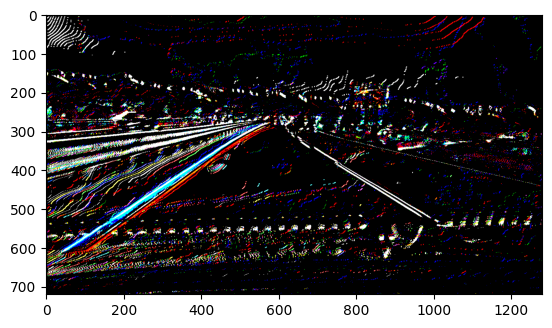

In [16]:
import cv2
import numpy as np
from sklearn.linear_model import RANSACRegressor
import matplotlib.pyplot as plt
# img = cv2.imread('/media/rideflux/T7/2024-Summer-Internship/벚꽃/04-03/2024-04-03-15-19-18_solati_v5_5_17-38/camera_0/31.jpg')
img = cv2.imread('/media/rideflux/T7/2024-Summer-Internship/NIA2021/10002/image0/10002_000.jpg')
img = cv2.resize(img, (1280, 720))
img = cv2.fastNlMeansDenoisingColored(img,None,10,10)

height, width = img.shape[0], img.shape[1]
img_half = img[height//2:, :,2]

sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
scale_factor = np.max(gradmag)/255
gradmag = (gradmag/scale_factor).astype(np.uint8)
th_mag = (10, 255)
gradient_magnitude = np.zeros_like(gradmag)
gradient_magnitude[(gradmag >= th_mag[0]) & (gradmag <= th_mag[1])] = 255

absgraddir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
gradient_direction = np.zeros_like(absgraddir)
th_dir = (0.7, 1.3)
gradient_direction[(absgraddir >= th_dir[0]) & (absgraddir <= th_dir[1])] = 255
gradient_direction = gradient_direction.astype(np.uint8)

grad_combine = np.zeros_like(gradient_direction).astype(np.uint8)
grad_combine[((sobel_x > 1) & (gradient_magnitude > 1) & (gradient_direction > 1)) | ((sobel_x > 1) & (sobel_y > 1))] = 255
plt.imshow(grad_combine)

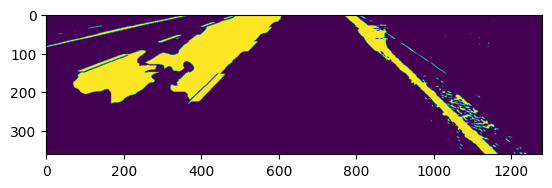

In [33]:
import cv2
import numpy as np
from sklearn.linear_model import RANSACRegressor
import matplotlib.pyplot as plt
img = cv2.imread('/media/rideflux/T7/2024-Summer-Internship/벚꽃/04-03/2024-04-03-15-19-18_solati_v5_5_17-38/camera_0/31.jpg')
# img = cv2.imread('/media/rideflux/T7/2024-Summer-Internship/NIA2021/10002/image0/10002_000.jpg')
img = cv2.resize(img, (1280, 720))
img = cv2.fastNlMeansDenoisingColored(img,None,10,10)

height, width = img.shape[0], img.shape[1]
img_half = img[height//2:, :]

hls = cv2.cvtColor(img_half, cv2.COLOR_BGR2HLS)

H = hls[: , : ,  0] # get Hue channel (색상)
L = hls[: , : ,  1] # get Light channel (밝기)
S = hls[: , : ,  2] # get Saturation channel (채도)
th_h, th_l, th_s = (160, 255), (30, 160), (0, 255)
h_img = np.zeros_like(H)
h_img[(H > th_h[0]) & (H <= th_h[1])] = 255
# plt.imshow(h_img)

l_img = np.zeros_like(L)
l_img[(L > th_l[0]) & (L <= th_l[1])] = 255
# plt.imshow(l_img)

s_img = np.zeros_like(S)
s_img[(S > th_s[0]) & (S <= th_s[1])] = 255
# plt.imshow(s_img)

hls_combine = np.zeros_like(s_img).astype(np.uint8)
hls_combine[((s_img > 1) & (l_img == 0)) | ((s_img == 0) & (h_img > 1) & (l_img > 1))] = 255 
plt.imshow(hls_combine)